# Tratamento das imagens

In [1]:
#Definir o diretorio onde serão armazenadas e retiradas as imagens
import pandas as pd 
import numpy as np
import tensorflow as tf
import skimage.segmentation as seg
import skimage.color as color
import os
import cv2

root_path = '/media/jaaoliveira/Dados/GIT/plantas'
os.chdir(root_path)

# Import Libraries

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [2]:
import tensorflow.compat.v1 as tfc
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto ()
config.gpu_options.allow_growth = True
session = InteractiveSession (config = config)

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
#!gdown https://drive.google.com/uc?id=115wev8oHTRnXleR78zArhSPCSDgNPAKy

# wandb

In [4]:
!wandb login 105561c81e9b7d48b0d2c9906184632bd993cc48

Traceback (most recent call last):
  File "/home/jaaoliveira/anaconda3/envs/tf-gpu/bin/wandb", line 10, in <module>
    sys.exit(cli())
TypeError: 'module' object is not callable


In [4]:
import wandb
from wandb.keras import WandbCallback

In [5]:
import random
import numpy as np
import pandas as pd 
import os
import cv2
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
root_path = '/media/jaaoliveira/Dados/GIT/plantas'
os.chdir(root_path)

In [7]:
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 4
IMG_SIZE = 512

print('Batch size:', BATCH_SIZE)

Batch size: 4


In [10]:
#!unzip -o plant-pathology-2020-fgvc7.zip

# Get train and test data

In [24]:
train = pd.read_csv(root_path + '/train_n.csv')
test = pd.read_csv(root_path + '/test_n.csv')
sub = pd.read_csv(root_path + '/sample_submission.csv')

print(train.head())

train_path = train.image_id.apply(lambda x: f'{root_path}/imagens_tratadas/{x}.jpg').values
test_path = test.image_id.apply(lambda x: f'{root_path}/imagens_tratadas/{x}.jpg').values
train_label = train.loc[:, 'healthy':].values

#Separa treino e validação
train_path, valid_path, train_label, valid_label, = train_test_split(train_path, train_label, test_size=0.05, random_state=123, stratify = train_label)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


# Get class weights

/home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 3 0 ... 2 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<BarContainer object of 4 artists>

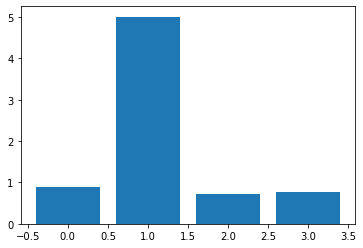

In [9]:
class_weight = compute_class_weight('balanced', np.unique(np.argmax(train_label, axis=1)), np.argmax(train_label, axis=1))
plt.bar(range(4), class_weight)

# Lets see some images

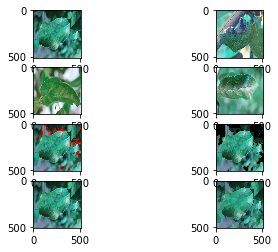

In [10]:
# 2×2で表示
fig, ax = plt.subplots(4, 2)
# サンプル読み込み
img = cv2.imread(root_path +'/imagens_tratadas/Train_0.jpg')
img1 = cv2.imread(root_path +'/imagens_tratadas/Train_1.jpg')
img2 = cv2.imread(root_path +'/imagens_tratadas/Train_2.jpg')
img3 = cv2.imread(root_path +'/imagens_tratadas/Train_3.jpg')
# 場所指定した書き出し
ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0, 1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[1, 0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1, 1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
img4 = cv2.imread(root_path +'/imagens_tratadas/Train_0_contour.jpg')
img5 = cv2.imread(root_path +'/imagens_tratadas/Train_0_cut.jpg')
img6 = cv2.imread(root_path +'/imagens_tratadas/Train_0_gaus.jpg')
img7 = cv2.imread(root_path +'/imagens_tratadas/Train_0_seg.jpg')
ax[2, 0].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax[2, 1].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax[3, 0].imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
ax[3, 1].imshow(cv2.cvtColor(img7, cv2.COLOR_BGR2RGB))

# Decode images

In [11]:
#Definição de conversão de dados (decodificação)
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
#     Leia os dados brutos
    bits = tf.io.read_file(filename)
#    Decodificar para tensor de imagem
    image = tf.image.decode_jpeg(bits, channels=3)
#     0-255のRGBを0-1に変換する（normalize）
    image = tf.cast(image, tf.float32) / 255.0
#     画像サイズを1365×2048から768×768にする
    image = tf.image.resize(image, image_size)
#    imageをreturn
    if label is None:
        return image
    else:
        return image, label

# データ変換（増幅）の定義
def data_augment(image, label=None):
#     ランダムに水平方向に反転
    image = tf.image.random_flip_left_right(image, seed=123)
#     ランダムに垂直方向に反転
    image = tf.image.random_flip_up_down(image, seed=123)
      

    if label is None:
        return image
    else:
        return image, label

In [25]:
# Decodificar dados
train_dataset = (
#  Ler e gravar dados em formato TFR
    tf.data.TFRecordDataset
#    Divida a matriz para construir o conjunto de dados
    .from_tensor_slices((train_path, train_label))
#    Execute a conversão de dados (decodificação) em paralelo
    .map(decode_image, num_parallel_calls=AUTO)
#    Execute a conversão de dados (amplificação) em paralelo
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024) #Elemento aleatório
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_dataset = (
#  Ler e gravar dados em formato TFR
    tf.data.TFRecordDataset
#    Divida a matriz para construir o conjunto de dados
    .from_tensor_slices((valid_path, valid_label))
#    Execute a conversão de dados (decodificação) em paralelo
    .map(decode_image, num_parallel_calls=AUTO)
#    Execute a conversão de dados (amplificação) em paralelo
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


# Dados de teste de decodificação
test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(test_path)
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [16]:
#list(train_dataset)

# Define the parameters

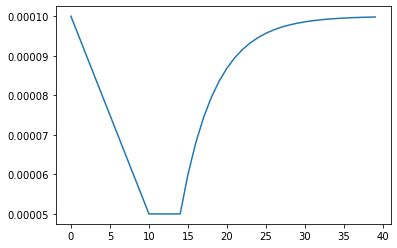

In [13]:
EPOCHS = 40
LR_START = 0.0001
LR_MAX = 0.00005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr = tf.keras.callbacks.LearningRateScheduler(lrfn)

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

# DenseNet

In [14]:
# DenseNet121,DenseNet169,DenseNet201が使用可能
from tensorflow.keras.applications import DenseNet121

dnn121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

model_dnn121 = Sequential()
model_dnn121.add(dnn121)
model_dnn121.add(L.GlobalAveragePooling2D())
model_dnn121.add(L.Dense(4, activation='softmax'))
model_dnn121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_dnn121.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________
None


# Model

In [15]:
wandb.init(project="trabalho-de-vc-wesley")

wandb: Currently logged in as: elitonperin (use `wandb login --relogin` to force relogin)


In [17]:
STEPS_PER_EPOCH = train_label.shape[0] // BATCH_SIZE

In [18]:
!ls

imagens
imagens_tratadas
imagens_tratadas-20201121T233801Z-001.zip
model-best.h5
passo_a_paso
plant_pathology_densenet.ipynb
resnet.py
sample_submission.csv
submission_dnn121_transformacoes_loss.csv
submission_resnet_.csv
test.csv
train.csv
training_resnet__1
train_n.csv
wandb
weights_dnn121.h5
weights_dnn121_transformacoes_loss.h5


In [19]:
mc_dnn121 = tf.keras.callbacks.ModelCheckpoint('weights_dnn121.h5', 
                                               monitor='loss', 
                                               save_best_only=True, save_weights_only=True)
history = model_dnn121.fit(train_dataset, 
                           epochs=EPOCHS, 
                           validation_data = val_dataset,
                           callbacks=[lr, mc_dnn121,
                                      WandbCallback(monitor='val_loss',
                                                   mode='max',
                                                   data_type='image',
                                                    #training_data=train_dataset
                                                    )
                                                    ], 
                           steps_per_epoch = STEPS_PER_EPOCH,
                           validation_steps=2)

Train for 2162 steps, validate for 2 steps
Epoch 1/40
2162/2162 [==============================] - 1081s 500ms/step - loss: 0.5594 - accuracy: 0.8008 - val_loss: 0.2282 - val_accuracy: 1.0000
Epoch 2/40
2162/2162 [==============================] - 1019s 471ms/step - loss: 0.3235 - accuracy: 0.8981 - val_loss: 0.0380 - val_accuracy: 1.0000
Epoch 3/40
2162/2162 [==============================] - 1019s 471ms/step - loss: 0.2365 - accuracy: 0.9244 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 4/40
2162/2162 [==============================] - 1019s 471ms/step - loss: 0.1804 - accuracy: 0.9392 - val_loss: 0.0367 - val_accuracy: 1.0000
Epoch 5/40
2162/2162 [==============================] - 1018s 471ms/step - loss: 0.1314 - accuracy: 0.9591 - val_loss: 0.0678 - val_accuracy: 1.0000
Epoch 6/40
2162/2162 [==============================] - 1018s 471ms/step - loss: 0.1007 - accuracy: 0.9679 - val_loss: 0.0591 - val_accuracy: 1.0000
Epoch 7/40
2162/2162 [==============================] - 1018s 4

In [35]:
model_dnn121.load_weights('/media/jaaoliveira/Dados/GIT/plantas/weights_dnn121.h5')
#model_dnn121.load_weights('/content/wandb/run-20201114_000046-ft2s6ors/files/model-best.h5')

# Validação

In [36]:
#Predizer com os dados de validação
pred = model_dnn121.predict(val_dataset, verbose=1, steps = valid_label.shape[0] // BATCH_SIZE)

114/114 [==============================] - 14s 122ms/step


In [37]:
# pred
# print(valid_label.shape)
from keras.utils import np_utils
pred = np_utils.to_categorical(np.argmax(pred, axis=1), dtype=int)
# dataf = pd.get_dummies(np.argmax(pred, axis=1))
# dataf

In [38]:
#Verificar a acurácia do modelo
print('accuracy: ', accuracy_score(valid_label, pred))
#Previsão em relação ao o que estou predizendo
print('precision: ', precision_score(valid_label, pred, average='weighted'))
#Previsão em relação das classes verdadeiras
print('recall: ', recall_score(valid_label, pred, average='weighted'))
#Média armônica dos dois precision e recall
print('f1_score: ', f1_score(valid_label, pred, average='weighted'))

accuracy:  0.9583333333333334
precision:  0.9595327998836771
recall:  0.9583333333333334
f1_score:  0.9572045375874115


In [ ]:
# plotar Matriz de Confusão entre classes
plot_confusion_matrix(model_dnn121, val_dataset, valid_label, values_format='d');

# Predict

In [39]:
probs_dnn121 = model_dnn121.predict(test_dataset, verbose=1)

2277/2277 [==============================] - 282s 124ms/step


In [40]:
n = 1820
final_res = []
for i, prob in enumerate(probs_dnn121[:1821]):
  n = n + 1
  vec = np.array(prob)
  # print(test_path[i])
  # print(test_path[n])
  # vec+=np.array(probs_dnn121[n])
  # print(test_path[n])
  n = n + 1
  vec+=np.array(probs_dnn121[n])
  # print(test_path[n])
  n = n + 1
  vec+=np.array(probs_dnn121[n])
  # print(test_path[n])
  n = n + 1
  vec+=np.array(probs_dnn121[n])
  # print(test_path[n])
  # print(vec/5)
  final_res.append(vec/4)
final_res
sub_dnn121 = sub
sub_dnn121.loc[:, 'healthy':] = final_res
sub_dnn121.to_csv('submission_dnn121_complet.csv', index=False)
sub_dnn121

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.009496,0.000254,9.891100e-01,1.139401e-03
1,Test_1,0.000070,0.000119,9.997244e-01,8.642961e-05
2,Test_2,0.000027,0.000010,6.923676e-07,9.999624e-01
3,Test_3,0.993066,0.000002,6.880451e-03,5.165613e-05
4,Test_4,0.000018,0.000078,9.999037e-01,2.102183e-07
...,...,...,...,...,...
1816,Test_1816,0.000074,0.000168,9.990349e-01,7.232679e-04
1817,Test_1817,0.174941,0.000156,2.983604e-02,7.950668e-01
1818,Test_1818,0.323665,0.006096,5.459520e-01,1.242874e-01
1819,Test_1819,0.899122,0.000032,7.655407e-02,2.429249e-02
